# Import Required Libraries
Import the necessary libraries for building and training the GAN model, as well as utilities for data handling and visualization.

In [14]:
import os
import numpy as np
import torch
from torch import nn, optim
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import dill
import warnings
warnings.filterwarnings("ignore", message=".*cudnnException.*")

In [15]:
import os
from PIL import Image
import shutil
from Basic_Neural_Network.inference_function_neural_network import run_inference_neural_network
import numpy as np

def create_reconstructed_dataset(activate=False):
    """
    Automatically accesses dataset directories and reconstructs images.
    The model file and dataset paths are fixed based on your structure.

    Args:
        activate (bool): Whether to activate this function.
    """
    if not activate:
        print("Reconstruction function is not activated.")
        return

    # Fixed paths based on your structure
    model_path = os.path.join("..", "saved_models", "Neural_network", "NeuralNetwork_ImageReconstruction.pth")
    base_dir = os.path.join("..", "Dataset")  # Original dataset
    reconstructed_dir = os.path.join(".", "Dataset_Reconstructed")  # Reconstructed dataset at the same level as the code

    # Auto-detect device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Define subdirectories (train, validation, test)
    subdirs = ["train", "validation", "test"]
    for subdir in subdirs:
        src_dir = os.path.join(base_dir, subdir)
        dest_dir = os.path.join(reconstructed_dir, subdir)

        # Check if source directory exists
        if not os.path.exists(src_dir):
            raise FileNotFoundError(f"Source directory not found: {src_dir}")

        # Remove and recreate destination directory
        if os.path.exists(dest_dir):
            shutil.rmtree(dest_dir)
        os.makedirs(dest_dir)

        # Traverse all images in the source directory
        for filename in os.listdir(src_dir):
            if filename.endswith("_masked.jpg"):
                # Load masked image
                masked_path = os.path.join(src_dir, filename)
                masked_image = Image.open(masked_path).convert("RGB")

                # Perform inference
                reconstructed_array = run_inference_neural_network(
                    model_path=model_path,
                    images=[masked_image],
                    grid_size=4,
                    target_size=(224, 224),
                    device=device
                )[0]  # Single image, so take the first result

                # Convert NumPy array to PIL.Image
                reconstructed_image = Image.fromarray(
                    np.clip(reconstructed_array, 0, 255).astype(np.uint8)
                )

                # Save reconstructed image
                original_filename = filename.replace("_masked.jpg", ".jpg")
                save_path = os.path.join(dest_dir, original_filename)
                reconstructed_image.save(save_path)

    print(f"Reconstructed dataset created at '{reconstructed_dir}'.")

# Call the function
create_reconstructed_dataset(
    activate=True  # Activate the function to execute
)


Using device: cuda
Reconstructed dataset created at '.\Dataset_Reconstructed'.


# Define Dataset Class
We create a custom dataset class to load pairs of original and masked images. The images are assumed to have the same name, with `_masked` appended to the masked image files.

In [16]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ImageMaskDataset(Dataset):
    """
    Custom Dataset to load original and masked image pairs.
    Assumes original images and masked images have the same name,
    with `_masked` appended to the masked images.
    """
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_files = [f for f in os.listdir(directory) if not f.endswith("_masked.jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        original_name = self.image_files[idx]
        masked_name = original_name.replace(".jpg", "_masked.jpg")

        original_path = os.path.join(self.directory, original_name)
        masked_path = os.path.join(self.directory, masked_name)

        # Load images
        original_img = Image.open(original_path).convert("RGB")
        masked_img = Image.open(masked_path).convert("RGB")

        if self.transform:
            original_img = self.transform(original_img)
            masked_img = self.transform(masked_img)

        return masked_img, original_img

# Define transformations to normalize image pixels to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors (auto-normalized to [0, 1])
])

# Base directory for the dataset
base_dir = os.path.join("..", "Dataset")

# Directories for train, validation, and test sets
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Initialize datasets
train_dataset = ImageMaskDataset(train_dir, transform=transform)
val_dataset = ImageMaskDataset(val_dir, transform=transform)
test_dataset = ImageMaskDataset(test_dir, transform=transform)

# Data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify dataset sizes and loader functionality
print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 9440, Validation samples: 1350, Test samples: 2710


# Define the Generator
The generator reconstructs original images from masked images by learning to map the masked inputs to the target distribution.

In [17]:
class Generator(nn.Module):
    """
    Generator network to reconstruct masked images.
    """
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),  # Upsample to 2x original size
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),  # Reduce to 3 channels
            nn.Tanh()
        )
        
        # Add a final resize to ensure output is 224x224
        self.resize = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
    
    def forward(self, x):
        x = self.model(x)
        x = self.resize(x)  # Ensure final size matches 224x224
        return x

generator = Generator()
print(generator)

Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
  )
  (resize): Upsample(size=(224, 224), mode='bilinear')
)


# Define the Discriminator
The discriminator classifies images as real (original) or fake (generated by the generator). This provides feedback to improve the generator.

In [18]:
class Discriminator(nn.Module):
    """
    Discriminator network to classify real vs. fake images.
    """
    def __init__(self, input_channels=3, image_size=224):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # Downsample to 112x112
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Downsample to 56x56
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Downsample to 28x28
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Downsample to 14x14
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),  # Downsample to 7x7
            nn.LeakyReLU(0.2)
        )
        
        # Compute the output size dynamically
        with torch.no_grad():
            test_input = torch.randn(1, input_channels, image_size, image_size)  # Test input
            conv_out = self.conv(test_input)
            self.flattened_size = conv_out.numel()  # Calculate flattened size
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 1),  # Match the dynamically calculated size
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv(x)  # Pass through convolutional layers
        x = self.model(x)  # Flatten and apply the linear + sigmoid layers
        return x
    
discriminator = Discriminator()
print(discriminator)

Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


# Define Loss Functions and Optimizers
We use Binary Cross-Entropy Loss (BCE) for both the generator and discriminator. Adam optimizers are used for both networks.

In [19]:
adversarial_loss = nn.BCELoss()  # Binary Cross-Entropy Loss
reconstruction_loss = nn.MSELoss() # 

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.000005, betas=(0.5, 0.999))

# Validation Function
The `validate` function evaluates the generator on the validation dataset. 
It computes the combined adversarial and reconstruction losses for the generated images.

In [20]:
def validate(generator, val_loader):
    generator.eval()  # Set generator to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for masked_imgs, original_imgs in val_loader:
            masked_imgs, original_imgs = masked_imgs.to(device), original_imgs.to(device)

            # Generate images
            gen_imgs = generator(masked_imgs)

            # Compute adversarial loss
            valid = torch.ones((masked_imgs.size(0), 1), device=device)
            adv_loss = adversarial_loss(discriminator(gen_imgs), valid)

            # Compute reconstruction loss
            pixel_loss = reconstruction_loss(gen_imgs, original_imgs)

            # Combine losses
            combined_loss = adv_loss + 10 * pixel_loss
            val_loss += combined_loss.item()

    return val_loss / len(val_loader)  # Average validation loss

# Visualize Generated Images
Compare the masked, generated, and original images to evaluate the GAN's performance.

In [21]:
def visualize_results(generator, data_loader):
    generator.eval()
    masked_imgs, original_imgs = next(iter(data_loader))
    masked_imgs, original_imgs = masked_imgs.to(device), original_imgs.to(device)
    gen_imgs = generator(masked_imgs)

    # Clamp images to [0, 1] to avoid clipping warnings
    masked_imgs = torch.clamp(masked_imgs, 0, 1)
    original_imgs = torch.clamp(original_imgs, 0, 1)
    gen_imgs = torch.clamp(gen_imgs, 0, 1)

    fig, axs = plt.subplots(3, 5, figsize=(15, 9))
    for i in range(5):
        axs[0, i].imshow(np.transpose(masked_imgs[i].cpu().numpy(), (1, 2, 0)))
        axs[0, i].axis("off")
        axs[0, i].set_title("Masked")

        axs[1, i].imshow(np.transpose(gen_imgs[i].cpu().detach().numpy(), (1, 2, 0)))
        axs[1, i].axis("off")
        axs[1, i].set_title("Generated")

        axs[2, i].imshow(np.transpose(original_imgs[i].cpu().numpy(), (1, 2, 0)))
        axs[2, i].axis("off")
        axs[2, i].set_title("Original")

    plt.show()


# Training Loop
The GAN is trained by alternately updating the generator and discriminator. The generator tries to fool the discriminator, while the discriminator tries to correctly classify real and fake images.

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

def train_gan(epochs):
    history = {"g_loss": [], "d_loss": [], "val_g_loss": []}
    
    for epoch in range(epochs):
        g_loss_epoch, d_loss_epoch = 0, 0
        
        for masked_imgs, original_imgs in train_loader:
            masked_imgs, original_imgs = masked_imgs.to(device), original_imgs.to(device)

            # Adversarial ground truths
            valid = torch.ones((masked_imgs.size(0), 1), device=device)
            fake = torch.zeros((masked_imgs.size(0), 1), device=device)

            # Train Generator
            optimizer_G.zero_grad()
            gen_imgs = generator(masked_imgs)
            
            # Compute adversarial loss
            valid = torch.ones((masked_imgs.size(0), 1), device=device)
            g_adv_loss = adversarial_loss(discriminator(gen_imgs), valid)
            
            # Compute reconstruction loss
            pixel_loss = reconstruction_loss(gen_imgs, original_imgs)
            
            # Combine losses (weighted sum)
            g_loss = g_adv_loss + 10 * pixel_loss  # Weight of 10 for reconstruction loss
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(original_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)

            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()


        # Log losses
        g_loss_epoch /= len(train_loader)
        d_loss_epoch /= len(train_loader)
        
        # Validation phase
        val_g_loss = validate(generator, val_loader)
        
        history["g_loss"].append(g_loss_epoch)
        history["d_loss"].append(d_loss_epoch)
        history["val_g_loss"].append(val_g_loss)


        print(f"Epoch [{epoch+1}/{epochs}] | G Loss: {g_loss_epoch:.4f} | D Loss: {d_loss_epoch:.4f} | Val G Loss: {val_g_loss:.4f}")
        
        # During training (after every 10 epochs)
        if (epoch + 1) % 50 == 0:
            visualize_results(generator, val_loader)

    return history

# Train the GAN
Train the GAN using the training dataset for a specified number of epochs.

In [23]:
history = train_gan(epochs=1)

Epoch [1/1] | G Loss: 0.8086 | D Loss: 0.6894 | Val G Loss: 0.7372


# Plot Training and Validation Losses
This function plots the generator's training and validation losses (`g_loss` and `val_g_loss`), as well as the discriminator's loss (`d_loss`). Validation loss is plotted with a dashed line for better distinction.

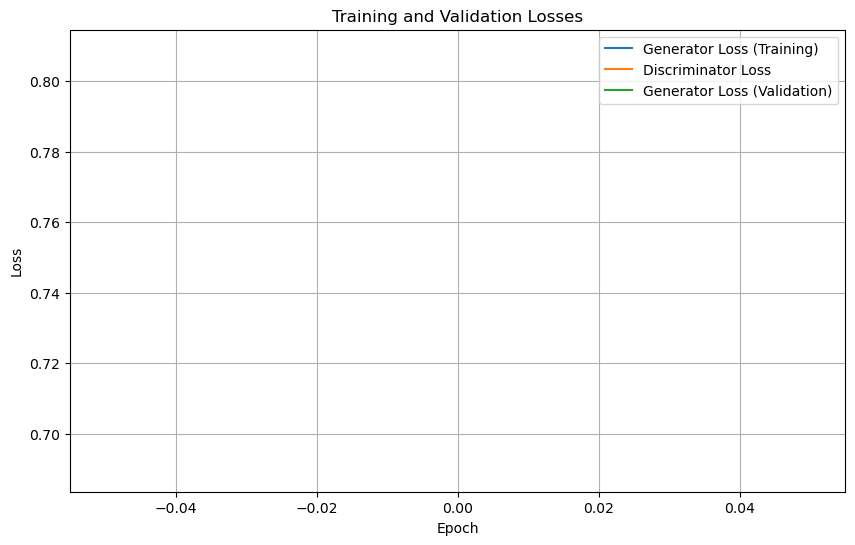

In [24]:
def plot_losses(history):
    
    plt.figure(figsize=(10, 6))
    # Plot generator loss (training)
    plt.plot(history["g_loss"], label="Generator Loss (Training)")
    
    # Plot discriminator loss
    plt.plot(history["d_loss"], label="Discriminator Loss")
    
    # Plot validation generator loss
    plt.plot(history["val_g_loss"], label="Generator Loss (Validation)")
    
    # Add labels, title, and legend
    plt.title("Training and Validation Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Call the function
plot_losses(history)

# Test Set Visualization
Display masked, generated, and original images from the test set.

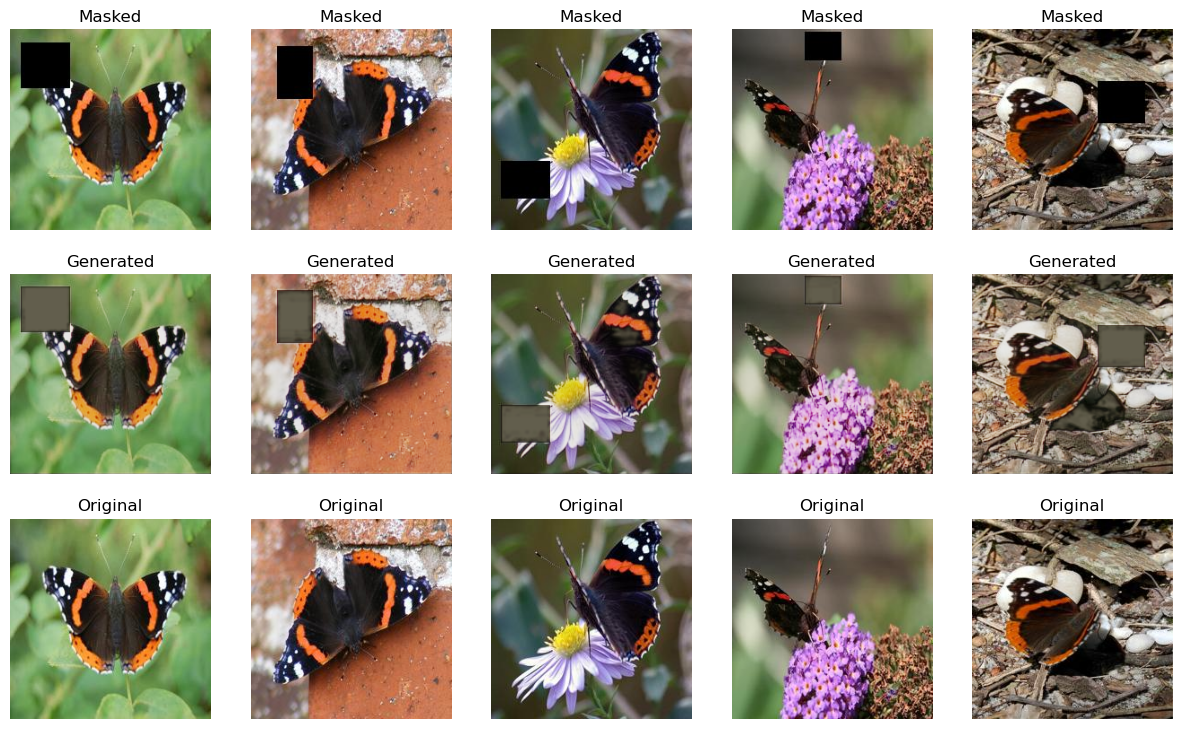

In [25]:
# Visualize a few images of the train set
visualize_results(generator, test_loader)

# Save Trained Models
Save the trained generator and discriminator models to a specified directory for later validation or reuse.

In [26]:
import os
import torch
import dill

# Parent directory for saving models, moved one level deeper
parent_dir = os.path.join("..", "saved_models", "GanModels")

# Create the parent directory if it doesn't exist
if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)

# Define the name and path for the subdirectory
sub_dir_name = "Small_training_testing"
sub_dir_path = os.path.join(parent_dir, sub_dir_name)

# Create the subdirectory if it doesn't exist
if not os.path.exists(sub_dir_path):
    os.makedirs(sub_dir_path)

# Define file paths for saving generator and discriminator models
generator_path = os.path.join(sub_dir_path, "generator_full.pth")
discriminator_path = os.path.join(sub_dir_path, "discriminator_full.pth")

# Save the full models using dill as the pickle module
torch.save(generator, generator_path, pickle_module=dill)
torch.save(discriminator, discriminator_path, pickle_module=dill)

# Inform the user of the save locations
print(f"Full Generator model saved to: {generator_path}")
print(f"Full Discriminator model saved to: {discriminator_path}")

Full Generator model saved to: ..\saved_models\GanModels\Small_training_testing\generator_full.pth
Full Discriminator model saved to: ..\saved_models\GanModels\Small_training_testing\discriminator_full.pth
